# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [107]:
# Imports here
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [136]:
data_dir = 'flower_data'

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
batch_size = 64
num_classes = 102

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def build_dataloaders(input_size):

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'valid': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

    image_datasets = {s: datasets.ImageFolder(os.path.join(data_dir, s), data_transforms[s])
                      for s in ['train', 'valid']
                     }

    dataloaders = {s: DataLoader(image_datasets[s], batch_size=batch_size, shuffle=True, num_workers=num_workers)
                   for s in ['train', 'valid']
                  }
    return image_datasets, dataloaders

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
list(cat_to_name.items())[:10]

[('21', 'fire lily'),
 ('3', 'canterbury bells'),
 ('45', 'bolero deep blue'),
 ('1', 'pink primrose'),
 ('34', 'mexican aster'),
 ('27', 'prince of wales feathers'),
 ('7', 'moon orchid'),
 ('16', 'globe-flower'),
 ('25', 'grape hyacinth'),
 ('26', 'corn poppy')]

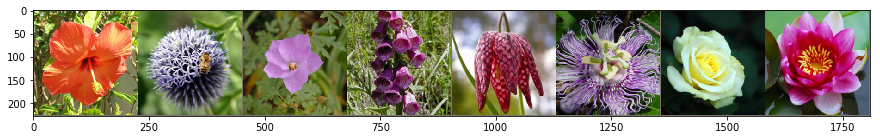

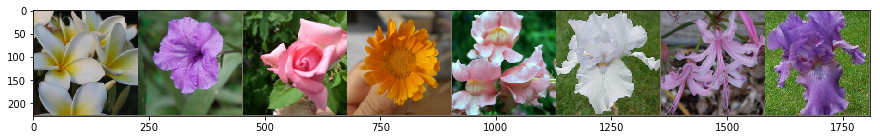

In [5]:
def grid_show(inputs):
    images = torchvision.utils.make_grid(inputs)
    images = images.numpy().transpose((1, 2, 0))
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    

_, dataloaders = build_dataloaders(224)
for s in ['train', 'valid']:
    plt.figure(figsize=(15, 12))
    inputs, _ = next(iter(dataloaders[s]))
    grid_show(inputs[:8])


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

### Init models functions

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
def init_model(model_name, num_classes, feature_extract=True, use_pretrained=True):
    
    model_ft = None
    input_size = 0
    
    if model_name == 'resnet':
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == 'alexnet':
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == 'vgg':
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == 'squeezenet':
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    
    elif model_name == 'densenet':
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == 'inception':
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299
    else:
        print('Invalid model name')
        return None, None
    
    return model_ft, input_size

In [8]:
def build_optimizer(model):
    params_to_update = []
    for _, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [95]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()
    
    acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
    
        acc = tuple()
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            dataset_size = len(dataloaders[phase].dataset)
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            acc += (epoch_acc,)
            
            print(f'{phase}\tLoss: {epoch_loss:.4f}\tAcc: {epoch_acc:.4f}')
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.copy(model.state_dict())
            if phase == 'valid':
                acc_history.append(acc)
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best Val Acc {best_acc:4f}')
    
    model.load_state_dict(best_model_wts)
    return model, acc_history, best_acc, time_elapsed


In [96]:
criterion = nn.CrossEntropyLoss()
num_epochs = 50

results = {}
for model_name in ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']:
    model, input_size = init_model(model_name, num_classes)
    image_datasets, dataloaders = build_dataloaders(input_size)
    
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, [0,1])
    model = model.to(device)
    
    optimizer = build_optimizer(model)
    print('=' * 90)
    print(model_name)
    print('=' * 90)
    model, acc_history, best_acc, time_elapsed = train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=(model_name == 'inception')) 
    
    results[model_name] = {
        'model': model,
        'acc_history': acc_history,
        'best_acc': best_acc,
        'time_elapsed': time_elapsed,
        'class_to_idx': image_datasets['train'].class_to_idx
    }

resnet
Epoch 0/49
----------
train	Loss: 4.2684	Acc: 0.1024
valid	Loss: 3.7675	Acc: 0.2274

Epoch 1/49
----------
train	Loss: 3.4767	Acc: 0.3132
valid	Loss: 3.1232	Acc: 0.3716

Epoch 2/49
----------
train	Loss: 2.9057	Acc: 0.4571
valid	Loss: 2.5868	Acc: 0.5122

Epoch 3/49
----------
train	Loss: 2.4646	Acc: 0.5696
valid	Loss: 2.2256	Acc: 0.5917

Epoch 4/49
----------
train	Loss: 2.1220	Acc: 0.6522
valid	Loss: 1.9153	Acc: 0.6919

Epoch 5/49
----------
train	Loss: 1.8551	Acc: 0.7294
valid	Loss: 1.6935	Acc: 0.7311

Epoch 6/49
----------
train	Loss: 1.6371	Acc: 0.7720
valid	Loss: 1.5028	Acc: 0.7897

Epoch 7/49
----------
train	Loss: 1.4705	Acc: 0.8028
valid	Loss: 1.3393	Acc: 0.8044

Epoch 8/49
----------
train	Loss: 1.3289	Acc: 0.8323
valid	Loss: 1.2355	Acc: 0.8289

Epoch 9/49
----------
train	Loss: 1.2032	Acc: 0.8524
valid	Loss: 1.1335	Acc: 0.8484

Epoch 10/49
----------
train	Loss: 1.1072	Acc: 0.8669
valid	Loss: 1.0444	Acc: 0.8655

Epoch 11/49
----------
train	Loss: 1.0198	Acc: 0.8808
val

valid	Loss: 0.3855	Acc: 0.8936

Epoch 41/49
----------
train	Loss: 0.1342	Acc: 0.9683
valid	Loss: 0.3834	Acc: 0.8912

Epoch 42/49
----------
train	Loss: 0.1337	Acc: 0.9683
valid	Loss: 0.3869	Acc: 0.8900

Epoch 43/49
----------
train	Loss: 0.1385	Acc: 0.9654
valid	Loss: 0.3804	Acc: 0.8851

Epoch 44/49
----------
train	Loss: 0.1293	Acc: 0.9686
valid	Loss: 0.3811	Acc: 0.8961

Epoch 45/49
----------
train	Loss: 0.1359	Acc: 0.9655
valid	Loss: 0.3786	Acc: 0.8973

Epoch 46/49
----------
train	Loss: 0.1306	Acc: 0.9692
valid	Loss: 0.3804	Acc: 0.8949

Epoch 47/49
----------
train	Loss: 0.1265	Acc: 0.9693
valid	Loss: 0.3847	Acc: 0.8949

Epoch 48/49
----------
train	Loss: 0.1188	Acc: 0.9737
valid	Loss: 0.3926	Acc: 0.8924

Epoch 49/49
----------
train	Loss: 0.1165	Acc: 0.9725
valid	Loss: 0.3842	Acc: 0.8912

Training complete in 12m 16s
Best Val Acc 0.897311
vgg
Epoch 0/49
----------
train	Loss: 4.0279	Acc: 0.1752
valid	Loss: 3.2991	Acc: 0.3790

Epoch 1/49
----------
train	Loss: 2.9333	Acc: 0.4431
v

/work/05791/andrec/maverick2/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/work/05791/andrec/maverick2/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


squeezenet
Epoch 0/49
----------
train	Loss: 3.4288	Acc: 0.2869
valid	Loss: 2.1083	Acc: 0.5330

Epoch 1/49
----------
train	Loss: 1.5414	Acc: 0.6554
valid	Loss: 1.1559	Acc: 0.7469

Epoch 2/49
----------
train	Loss: 0.9466	Acc: 0.7788
valid	Loss: 0.7964	Acc: 0.8252

Epoch 3/49
----------
train	Loss: 0.7014	Acc: 0.8443
valid	Loss: 0.6542	Acc: 0.8496

Epoch 4/49
----------
train	Loss: 0.5655	Acc: 0.8719
valid	Loss: 0.5734	Acc: 0.8680

Epoch 5/49
----------
train	Loss: 0.4730	Acc: 0.8947
valid	Loss: 0.4992	Acc: 0.8888

Epoch 6/49
----------
train	Loss: 0.4133	Acc: 0.9104
valid	Loss: 0.4695	Acc: 0.8912

Epoch 7/49
----------
train	Loss: 0.3705	Acc: 0.9212
valid	Loss: 0.4384	Acc: 0.8998

Epoch 8/49
----------
train	Loss: 0.3350	Acc: 0.9313
valid	Loss: 0.4275	Acc: 0.9108

Epoch 9/49
----------
train	Loss: 0.3083	Acc: 0.9361
valid	Loss: 0.3973	Acc: 0.9034

Epoch 10/49
----------
train	Loss: 0.2832	Acc: 0.9417
valid	Loss: 0.3822	Acc: 0.9169

Epoch 11/49
----------
train	Loss: 0.2585	Acc: 0.9495

/work/05791/andrec/maverick2/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


densenet
Epoch 0/49
----------
train	Loss: 4.2231	Acc: 0.1247
valid	Loss: 3.7362	Acc: 0.2494

Epoch 1/49
----------
train	Loss: 3.3917	Acc: 0.3610
valid	Loss: 3.0301	Acc: 0.4511

Epoch 2/49
----------
train	Loss: 2.7709	Acc: 0.5124
valid	Loss: 2.4755	Acc: 0.5966

Epoch 3/49
----------
train	Loss: 2.3022	Acc: 0.6323
valid	Loss: 2.0638	Acc: 0.6834

Epoch 4/49
----------
train	Loss: 1.9440	Acc: 0.7263
valid	Loss: 1.7745	Acc: 0.7335

Epoch 5/49
----------
train	Loss: 1.6654	Acc: 0.7871
valid	Loss: 1.5450	Acc: 0.7824

Epoch 6/49
----------
train	Loss: 1.4532	Acc: 0.8298
valid	Loss: 1.3472	Acc: 0.8252

Epoch 7/49
----------
train	Loss: 1.2741	Acc: 0.8634
valid	Loss: 1.1938	Acc: 0.8460

Epoch 8/49
----------
train	Loss: 1.1381	Acc: 0.8872
valid	Loss: 1.0963	Acc: 0.8460

Epoch 9/49
----------
train	Loss: 1.0285	Acc: 0.8997
valid	Loss: 0.9879	Acc: 0.8716

Epoch 10/49
----------
train	Loss: 0.9316	Acc: 0.9110
valid	Loss: 0.9054	Acc: 0.8826

Epoch 11/49
----------
train	Loss: 0.8548	Acc: 0.9191
v

valid	Loss: 1.0602	Acc: 0.8496

Epoch 41/49
----------
train	Loss: 1.2638	Acc: 0.8501
valid	Loss: 1.0462	Acc: 0.8447

Epoch 42/49
----------
train	Loss: 1.2457	Acc: 0.8538
valid	Loss: 1.0142	Acc: 0.8521

Epoch 43/49
----------
train	Loss: 1.2339	Acc: 0.8530
valid	Loss: 0.9980	Acc: 0.8509

Epoch 44/49
----------
train	Loss: 1.2118	Acc: 0.8523
valid	Loss: 0.9954	Acc: 0.8509

Epoch 45/49
----------
train	Loss: 1.1816	Acc: 0.8596
valid	Loss: 0.9679	Acc: 0.8570

Epoch 46/49
----------
train	Loss: 1.1726	Acc: 0.8590
valid	Loss: 0.9746	Acc: 0.8545

Epoch 47/49
----------
train	Loss: 1.1417	Acc: 0.8649
valid	Loss: 0.9454	Acc: 0.8557

Epoch 48/49
----------
train	Loss: 1.1227	Acc: 0.8651
valid	Loss: 0.9223	Acc: 0.8606

Epoch 49/49
----------
train	Loss: 1.1099	Acc: 0.8686
valid	Loss: 0.9051	Acc: 0.8643

Training complete in 17m 40s
Best Val Acc 0.864303


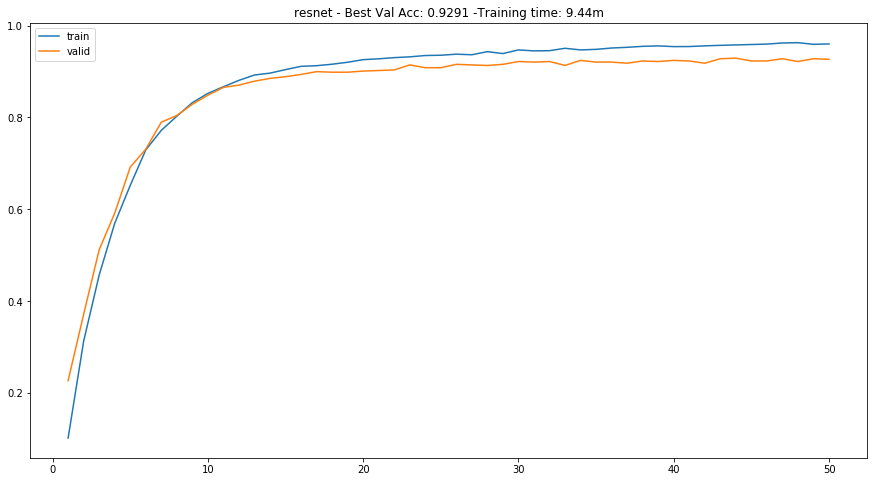

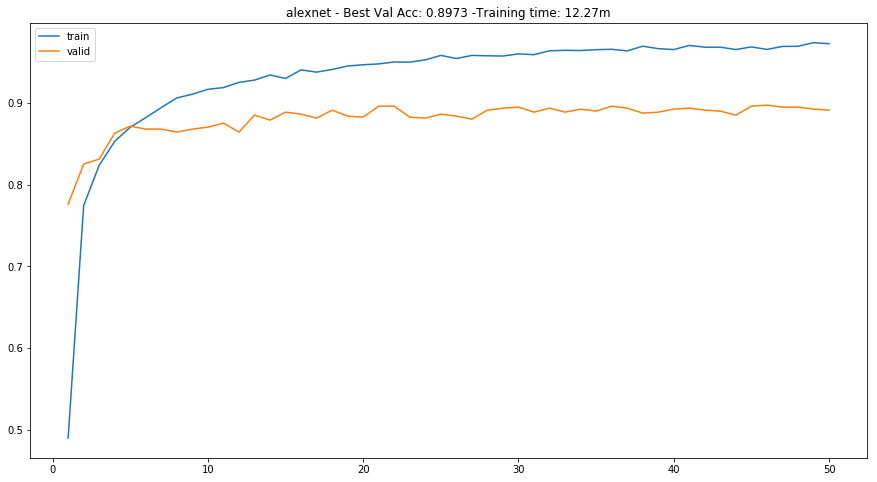

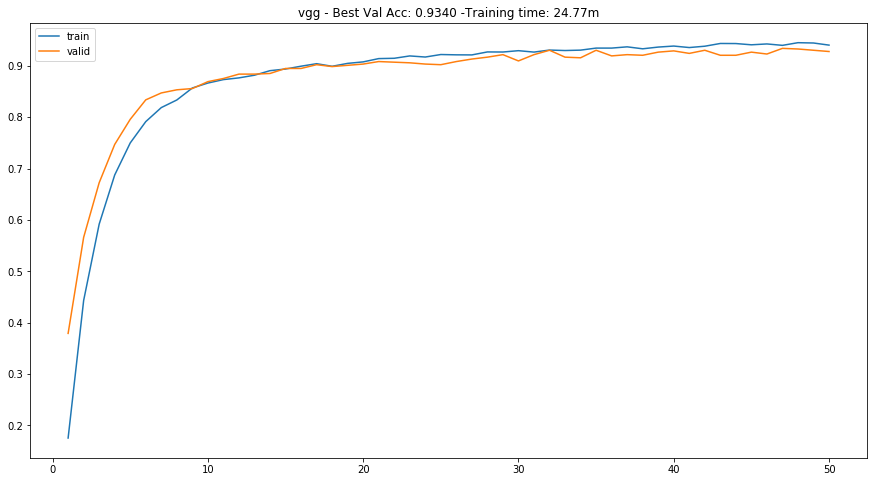

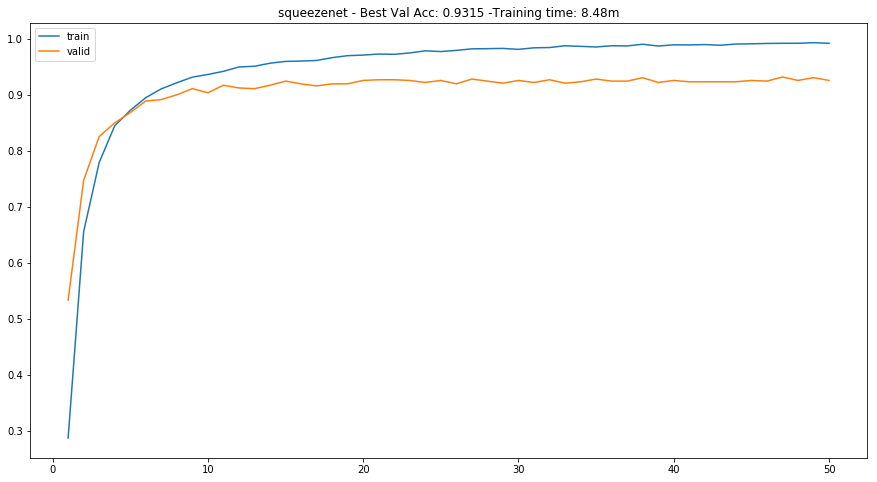

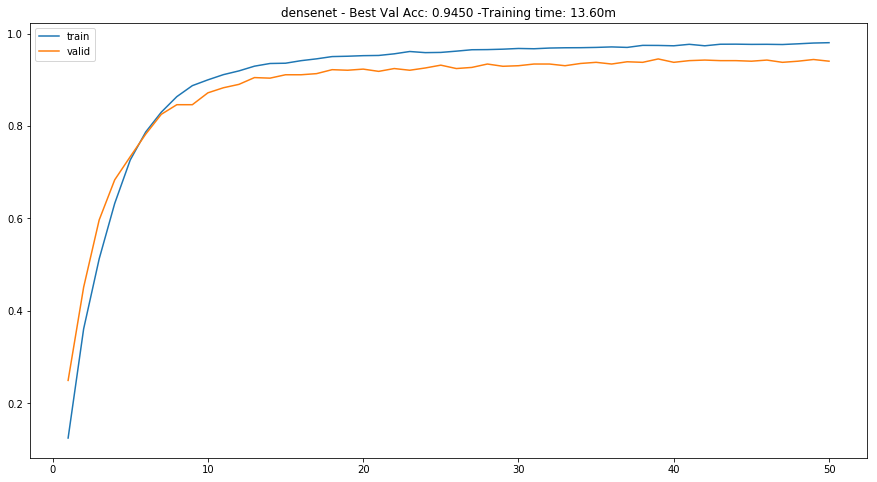

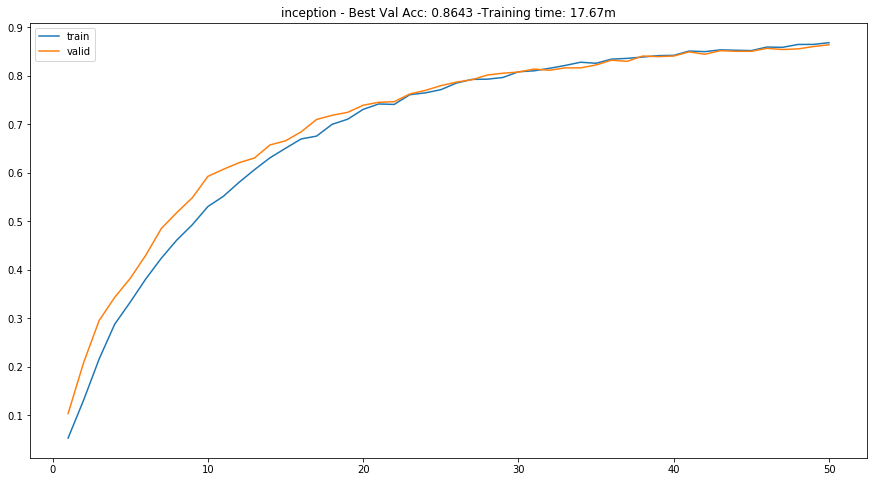

In [103]:
epochs = np.arange(1, num_epochs + 1, 1)
for model_name, model_results in results.items():
    plt.figure(figsize=(15, 8))
    lineObjs = plt.plot(epochs, model_results['acc_history'])
    plt.legend(lineObjs, ('train', 'valid'))
    plt.title(f"{model_name} - "
              f"Best Val Acc: {model_results['best_acc'].item():.4f} -" 
              f"Training time: {model_results['time_elapsed']/60:.2f}m")

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [104]:
# TODO: Save the checkpoint 
for model_name, model_results in results.items():
    results_filename = f'./{model_name}.tar'
    print(results_filename)
    
    model = model_results['model'].module
    torch.save({
        'model': model.state_dict(),
        'class_to_idx': model_results['class_to_idx'],
    }, results_filename)


./resnet.tar
./alexnet.tar
./vgg.tar
./squeezenet.tar
./densenet.tar
./inception.tar


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [185]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
model_name = 'vgg'
checkpoint = torch.load(f'{model_name}.tar')
model, input_size = init_model(model_name, num_classes)
model.load_state_dict(checkpoint['model'])
model.eval()

class_to_idx = checkpoint['class_to_idx']
idx_to_class = {v: k for k, v in class_to_idx.items()}

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, [0,1])
model = model.to(device)
input_size, model

(224, DataParallel(
   (module): VGG(
     (features): Sequential(
       (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU(inplace)
       (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
       (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (6): ReLU(inplace)
       (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
       (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (10): ReLU(inplace)
       (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [146]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open(image)
    target_resize = 256
    old_size = img.size
    ratio = target_resize / min(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    img = img.resize(new_size)
    left = (new_size[0] - input_size) / 2
    top = (new_size[1] - input_size) / 2
    right = (new_size[0] + input_size) / 2
    bottom = (new_size[1] + input_size) / 2
    img = img.crop((left, top, right, bottom))
    
    np_image = np.array(img)
    np_image = np_image / 255
    np_image = (np_image - mean)/std
    np_image = np_image.transpose((2, 0, 1))
    
    return torch.from_numpy(np_image)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [132]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

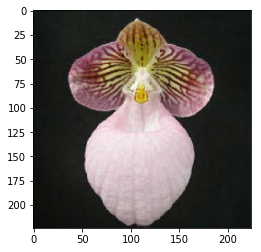

In [149]:
imshow(process_image('flower_data/valid/2/image_05136.jpg'));

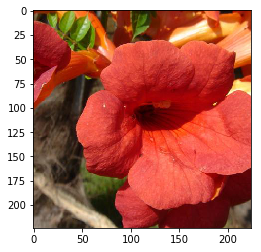

In [151]:
imshow(process_image('flower_data/train/101/image_07946.jpg'));

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [193]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    image = process_image(image_path)
    image = image.unsqueeze(0)
    image = image.to(device).float()
    pred = model(image)
    pred = pred.squeeze().cpu().detach()
    probs, labels = pred.topk(topk)
    probs = list(probs.numpy())
    classes = [idx_to_class[l] for l in labels.numpy()]
    return probs, classes
    

In [194]:
predict('flower_data/valid/2/image_05136.jpg', model)

([19.338171, 6.0241356, 5.6772747, 5.165696, 4.1616464],
 ['2', '52', '18', '48', '16'])

In [197]:
predict('flower_data/valid/14/image_06082.jpg', model)

([15.494691, 9.921053, 8.457305, 7.8307323, 6.2919645],
 ['14', '35', '10', '29', '12'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes